## Music collection visualization
Guillermo A. R.
06/03/2024

This assignment explores visualization of music collections using dimensionality reduction. Your submission can use the visualization notebook provided under the resources for this assignment. Recompute or load the feature vectors that you used for genre classification of the GTZAN collection instead of the .arff file used in the notebook. 

- As visualizing all 10 genres gets a bit too cluttered select the subset of 600 feature vectors corresponding to the following genres: classical, country, disco, hiphop, jazz, rock (btw these 6 were the ones used in my original early paper on musical genre classification and then subsequently extended to 10).


In [1]:
import numpy as np
import os
import librosa
import glob
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm, metrics
from sklearn.model_selection import cross_val_predict

In [2]:
path = Path(os.getcwd()) # Get current directory
fnames = glob.glob(str(path.parent) + "\\data\\genres_original\\*\\*.wav") # Go to parent folder to find data

genres = ['classical', 'country', 'disco', 'hiphop', 'jazz', 'rock', 'blues', 'reggae', 'pop', 'metal']

# allocate matrix for audio features and target 
audio_features = np.zeros((len(fnames), 40))
target = np.zeros(len(fnames))

# compute the features 
for (i,fname) in enumerate(fnames): 
    # print("Processing %d %s" % (i, fname))
    for (label,genre) in enumerate(genres): 
        if genre in fname: 
            audio, srate = librosa.load(fname)
            mfcc_matrix = librosa.feature.mfcc(y=audio, sr=srate)
            mean_mfcc = np.mean(mfcc_matrix,axis=1)
            std_mfcc = np.std(mfcc_matrix, axis=1)
            audio_fvec = np.hstack([mean_mfcc, std_mfcc])
            audio_features[i] = audio_fvec
            target[i] = label

In [3]:
# Reduce dataset to desired genres
index = np.argwhere(target<6).flatten()
audio_features = audio_features[index,:]
y = target[index]

print(audio_features.shape)
print(y.shape)

(600, 40)
(600,)


- Show the 2-dimensional plots with points coloured by genre similar to the provided notebook but for the 6 genres mentioned above using 2 dimensionality reduction methods: Principal Component Analysis (PCA) and t-stochastic network embedding (t-SNE).

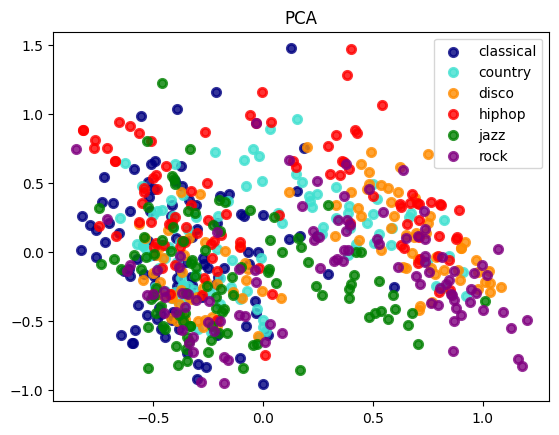

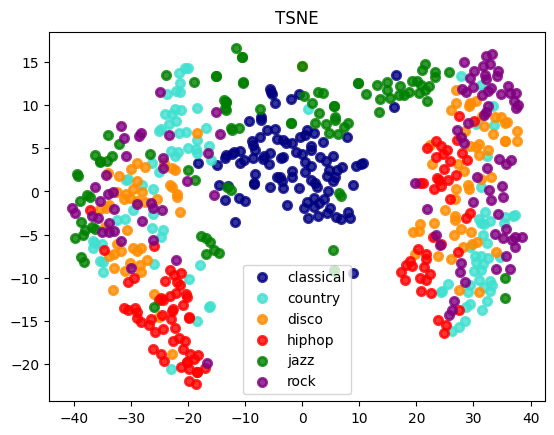

In [4]:
X = MinMaxScaler().fit_transform(np.asarray(audio_features))

target_names = genres[0:6]
colors = ['navy', 'turquoise', 'darkorange', 'red', 'green', 'purple']

def plot_scatter(X, title): 
    lw = 2
    #fig = plt.figure(1, figsize=(8, 6))
    for color, i, target_name in zip(colors, np.arange(6), target_names):
        plt.scatter(X[y == i, 0], X[y == i, 1], color=color, alpha=.8, 
                    lw=lw, label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(title)
    plt.show()

# Two dimensional PCA 
X_pca = PCA(n_components=2).fit_transform(X)
plot_scatter(X_pca, 'PCA')

# Two dimensional TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)
plot_scatter(X_tsne, 'TSNE')


- Lets add some visual information to the plots. Add a horizontal and vertical line passing through the middle to create 4 quadrants. For each genre calculate the centroid point (i.e the average of the x coordinates for a particular genre as x and the average of the y coordinates as y). Plot a text label corresponding to the name of the genre at that centroid location. This provides some more semantic information to the user.

C:\Users\g.aramburorodriguez\AppData\Local\Temp\ipykernel_16304\54012927.py:8: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(X[y == i, 0]), np.mean(X[y == i, 1]), marker='x',


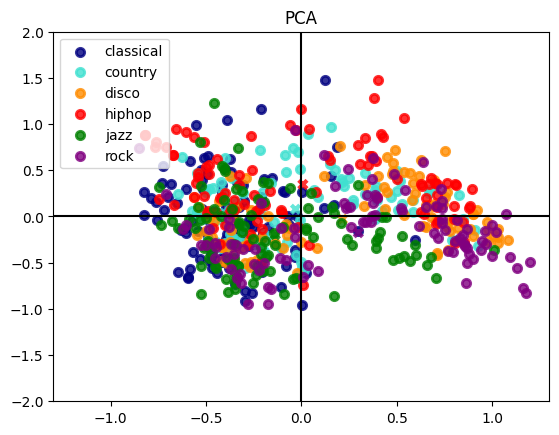

C:\Users\g.aramburorodriguez\AppData\Local\Temp\ipykernel_16304\54012927.py:8: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(np.mean(X[y == i, 0]), np.mean(X[y == i, 1]), marker='x',


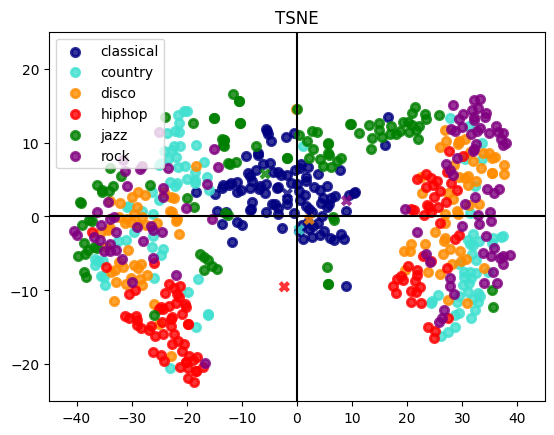

In [5]:
def plot_scatter(X, title): 
    lw = 2
    #fig = plt.figure(1, figsize=(8, 6))
    for color, i, target_name in zip(colors, np.arange(6), target_names):
        plt.scatter(X[y == i, 0], X[y == i, 1], color=color, alpha=.8, 
                    lw=lw, label=target_name)
        # Centroids are the same color but with a "x" marker
        plt.scatter(np.mean(X[y == i, 0]), np.mean(X[y == i, 1]), marker='x',
                     edgecolor='black', linewidth=3, facecolor=color, alpha=.8, 
                     hatch='|')

    plt.legend(loc='upper left', shadow=False, scatterpoints=1)
    plt.title(title)

# Two dimensional PCA 
X_pca = PCA(n_components=2).fit_transform(X)
plot_scatter(X_pca, 'PCA')
plt.plot([-1.3, 1.3], [0, 0], 'black')
plt.plot([0, 0], [-2, 2], 'black')
plt.xlim((-1.3,1.3))
plt.ylim((-2,2))
plt.show()

# Two dimensional TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)
plot_scatter(X_tsne, 'TSNE')
plt.plot([-45, 45], [0, 0], 'black')
plt.plot([0, 0], [-25, 25], 'black')
plt.xlim((-45,45))
plt.ylim((-25,25))
plt.show()

- We will consider a made-up metric of purity which is the sum of purity metrics for each quadrant. The purity of a quadrant is defined as the number of points for the genre that is the majority in that quadrant divided by the total number of points in the quadrant. The purity of each quadrant should be calculated and then added to provide a metric that roughly correlates to how good the visualization is.

In [6]:
def purity(X):
    checkSize = np.zeros((6,4))
    pur = np.zeros(4)
    for i in np.arange(6):
        # index for genre
        gnr = X[y==i,:]
        # index of coordinates of quadrant 1
        qdr1 = gnr[gnr>0]
        cond = (gnr[:,0]<0) * (gnr[:,1]>0)
        qdr2 = gnr[cond]
        qdr3 = gnr[gnr<0]
        cond = (gnr[:,0]>0) * (gnr[:,1]<0)
        qdr4 = gnr[cond]
        # Check size
        checkSize[i,0] = len(qdr1)
        checkSize[i,1] = len(qdr2)
        checkSize[i,2] = len(qdr3)
        checkSize[i,3] = len(qdr4)

    # Calculate purity of quadrant
    pur[0] = np.max(checkSize[:,0]) / np.sum(checkSize[:,0])
    pur[1] = np.max(checkSize[:,1]) / np.sum(checkSize[:,1])
    pur[2] = np.max(checkSize[:,2]) / np.sum(checkSize[:,2])
    pur[3] = np.max(checkSize[:,3]) / np.sum(checkSize[:,3])

    return np.sum(pur)

- Using this made-up metric compare the PCA visualization and the t-SNE. Does the result correspond to what you perceive visually?

In [7]:
print("Purity of PCA: " + str(purity(X_pca)))
print("Purity of t-SNE: " + str(purity(X_tsne)))

Purity of PCA: 1.1327733424590738
Purity of t-SNE: 1.0666185181654162


It's hard to draw a conclusion as in both methods there's a lot of overlap between genres. The t-SNE visualization spreads over a larger range which does aligh visually with the purity metric.

- Using the dimensionality reduced feature vectors i.e the x,y coordinates and NOT the original feature vectors perform a classification experiment using a linear SVM and 10-fold cross-validation to compute the classification accuracy. How much does the classification accuracy degrade when using the dimensionality reduced feature vectors for PCA and t-SNE?

I'll first use the original feature vectors to have a reference for PCA and t-SNE:

In [13]:
clf = svm.SVC(gamma='scale', kernel='linear')
clf.fit(audio_features, y)
predicted = cross_val_predict(clf, audio_features, y, cv=10)

print("Classification accuracy for a linear SVM using MFCC as audio features %s:\n%s\n"
      % (clf, metrics.accuracy_score(y, predicted)))

Classification accuracy for a linear SVM using MFCC as audio features SVC(kernel='linear'):
0.6683333333333333



In [12]:
clf.fit(X_pca, y)
predicted = cross_val_predict(clf, X_pca, y, cv=10)

print("Classification accuracy for a linear SVM using PCA as audio features %s:\n%s\n"
      % (clf, metrics.accuracy_score(y, predicted)))

Classification report for classifier SVC(kernel='linear'):
0.265



In [14]:
clf.fit(X_tsne, y)
predicted = cross_val_predict(clf, X_tsne, y, cv=10)

print("Classification accuracy for a linear SVM using t-SNE as audio features %s:\n%s\n"
      % (clf, metrics.accuracy_score(y, predicted)))

Classification accuracy for a linear SVM using t-SNE as audio features SVC(kernel='linear'):
0.30666666666666664



The dimensionality reduction severely impacts the performance of the classifier, it goes to an accuaracy less than half.